## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Importing dataset from kaggle

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d nodoubttome/skin-cancer9-classesisic

Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic
License(s): other
skin-cancer9-classesisic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/skin-cancer9-classesisic.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#### Import libraries

In [6]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

#### Defining the path for train and test images

In [7]:

data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

####  Count the number of image in Train and Test directory

In [8]:
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Data Vizualization


Found 2239 files belonging to 9 classes.


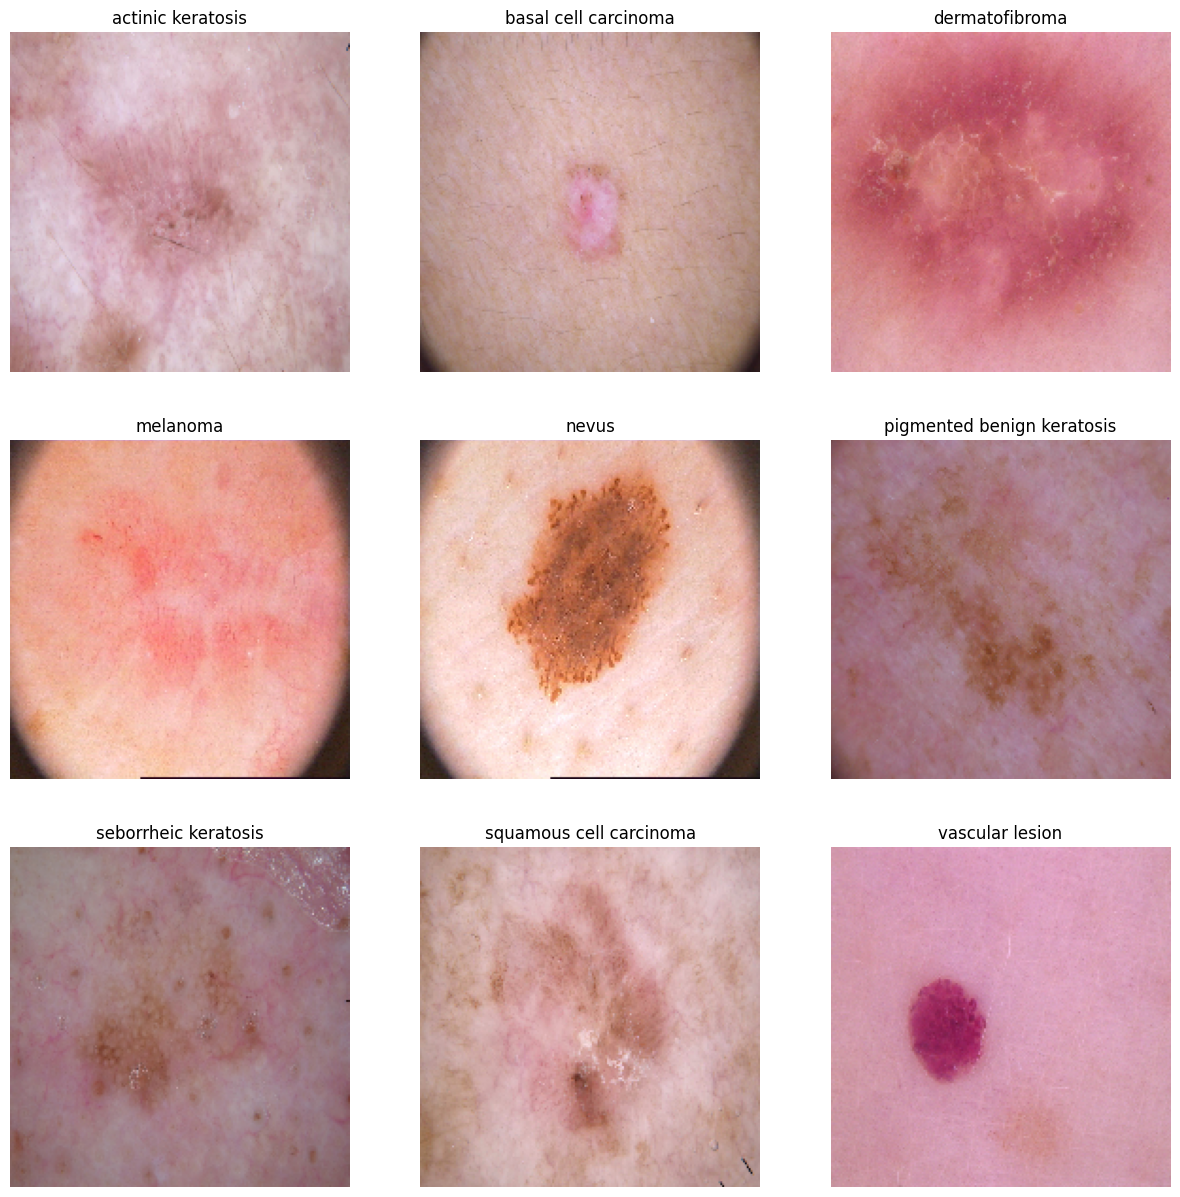

In [9]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [10]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,nevus,357
2,vascular lesion,139
3,dermatofibroma,95
4,pigmented benign keratosis,462
5,seborrheic keratosis,77
6,basal cell carcinoma,376
7,squamous cell carcinoma,181
8,actinic keratosis,114


<Axes: xlabel='No. of Image', ylabel='Class'>

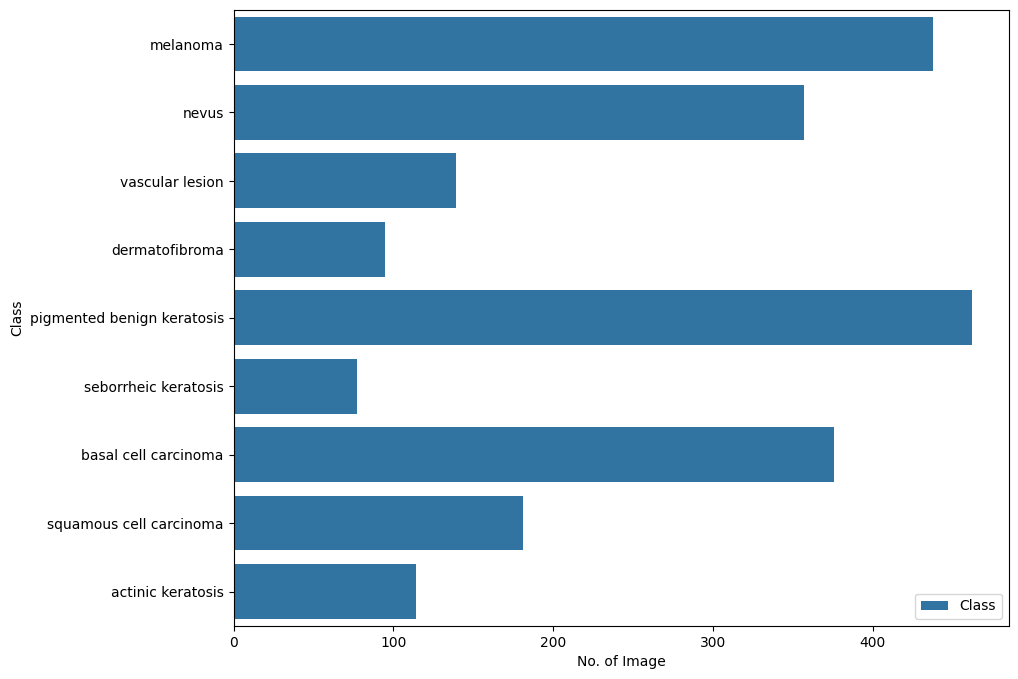

In [11]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [13]:
# There is a class imbalance problem to solve this we are using -- Data Augmentation

#### Augmentation

In [12]:
# install Augmentator
!pip install Augmentor

In [13]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796334140E90>: 100%|██████████| 500/500 [00:18<00:00, 27.09 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79635F591690>: 100%|██████████| 500/500 [00:16<00:00, 30.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7963379A2A10>: 100%|██████████| 500/500 [00:14<00:00, 35.41 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2269x1965 at 0x7963341F9A90>: 100%|██████████| 500/500 [01:17<00:00,  6.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7963340476D0>: 100%|██████████| 500/500 [01:14<00:00,  6.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796334050CD0>: 100%|██████████| 500/500 [00:13<00:00, 37.38 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7963379AB5D0>: 100%|██████████| 500/500 [00:32<00:00, 15.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79633799C450>: 100%|██████████| 500/500 [00:13<00:00, 37.29 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796355BD4150>: 100%|██████████| 500/500 [00:13<00:00, 38.35 Samples/s]


In [14]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Model Building

In [15]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [16]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Normalization of Train and test

In [17]:
def process (image , label):
  image = tf.cast(image/255. , tf.float32)
  return image , label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [18]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Rescaling

## CNN Model Architecture

In [19]:
#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(Rescaling(1./255, input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))


#Dense Layer 2
model.add(layers.Dense(64,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))


#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,656,713 (25.39 MB)

 Trainable params: 6,656,265 (25.39 MB)

 Non-trainable params: 448 (1.75 KB)

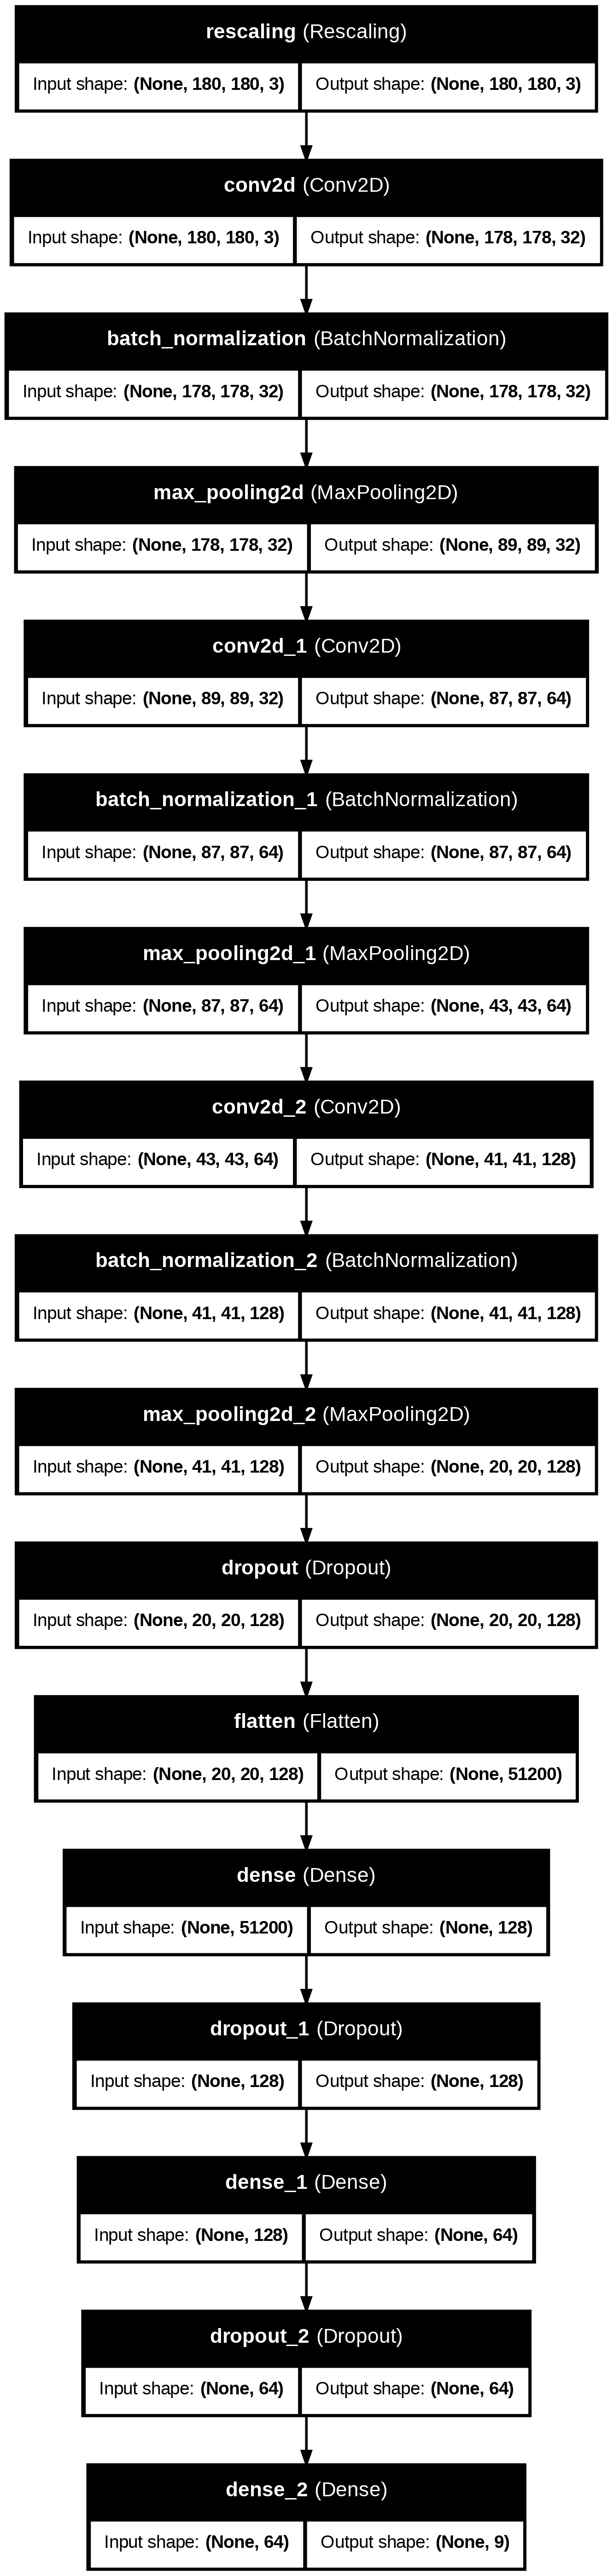

In [20]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the Model

In [21]:
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.


#Stop training when a monitored metric has stopped improving. - - - -  Accuracry was reducing using earlystoping
#earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

## Train the model


In [24]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,batch_size = 32)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.8698 - loss: 0.3542 - val_accuracy: 0.1381 - val_loss: 36.9131
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 154ms/step - accuracy: 0.8818 - loss: 0.3403 - val_accuracy: 0.1359 - val_loss: 78.9861
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - accuracy: 0.8819 - loss: 0.3704 - val_accuracy: 0.1329 - val_loss: 26.7314
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.8780 - loss: 0.3796 - val_accuracy: 0.4239 - val_loss: 3.5945
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.8959 - loss: 0.2979 - val_accuracy: 0.4989 - val_loss: 1.9278
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.9012 - loss: 0.2994 - val_accuracy: 0.2635 - val_loss: 6.9244
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9157 - loss: 0.2211 - val_accuracy: 0.1359 - val_loss: 57.9468
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9104 - los

### Plot the training curves

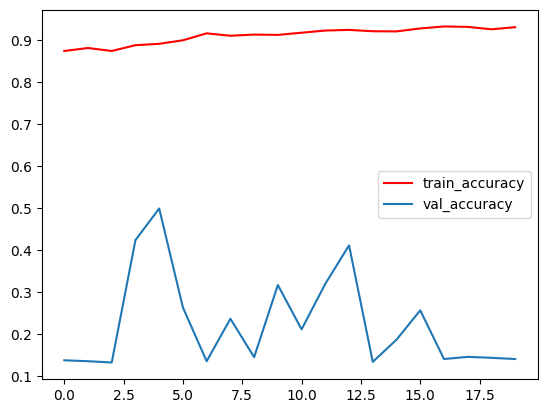

In [26]:
plt.plot(history.history['accuracy'],color = 'red', label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [27]:
import cv2

In [40]:
test_img = cv2.imread('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000022.jpg')

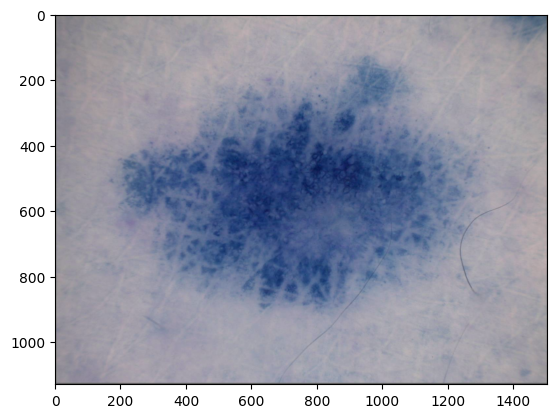

In [41]:
plt.imshow(test_img)

In [42]:
test_img = cv2.resize(test_img,(180,180))

In [43]:
test_input =test_img.reshape((1,180,180,3))

In [44]:
predictions =model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [45]:
# Get the predicted class index from the predictions, not the image data
predicted_class_index = np.argmax(predictions[0])

# Assuming 'class_names' is defined as in the provided code (list of class names).
predicted_class_name = class_names[predicted_class_index]

print(f"The image is predicted to be of class: {predicted_class_name}")

The image is predicted to be of class: melanoma
